In [246]:
import torch
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.stats import norm
from scipy.stats.distributions import chi2
from random import shuffle
from matplotlib.animation import FuncAnimation
from scipy.stats import multivariate_normal

## Creating Dataset

Two multi variate gaussian clusters dataset

In [247]:
# Fix seeds
random.seed(15)
np.random.seed(15)
torch.manual_seed(15)


c1 = plt.get_cmap('coolwarm')(0.0)
c2 = plt.get_cmap('coolwarm')(1.0)

plt_cmap = sns.color_palette("coolwarm", as_cmap=True)

In [248]:
def make_dataset(mean, cov, v=None, separation=1, n=200):
    x1 = np.random.multivariate_normal(mean, cov, size=n)
    if v is None:
        v = np.random.randn(2,)
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    elif np.linalg.norm(v) != separation:
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    else:
        v = v.reshape(1, -1)
    x2 = x1 + v
    X = np.concatenate([x1, x2], axis=0)
    y = np.array([0] * len(x1) + [1] * len(x2))

    return X, y

In [249]:
n_dim = 2
n_classes = 2
n_datasets = 4
device = 'cpu'

In [250]:
mu = np.array([0, 0])
separation = 6
A = np.random.randn(2, 2)
cov = .1 * np.dot(A.T, A) + np.eye(2)
v = np.array([np.cos((np.pi / 180) * 45), np.sin((np.pi / 180) * 45)])
X, y = make_dataset(mu, cov, v=v, separation=separation, n=400)
Xt = torch.from_numpy(X).float()
Yt = torch.nn.functional.one_hot(torch.from_numpy(y).long(), num_classes=2).float()

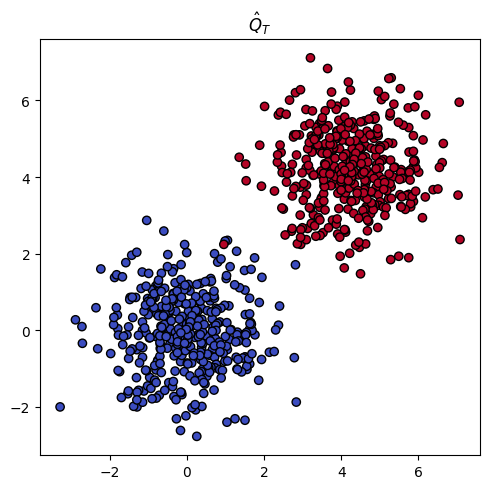

In [251]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(x=Xt[:, 0], y=Xt[:, 1], c=y, cmap='coolwarm', edgecolor='k')
ax.set_title(r"$\hat{Q}_{T}$")
plt.tight_layout()

Arc shaped dataset

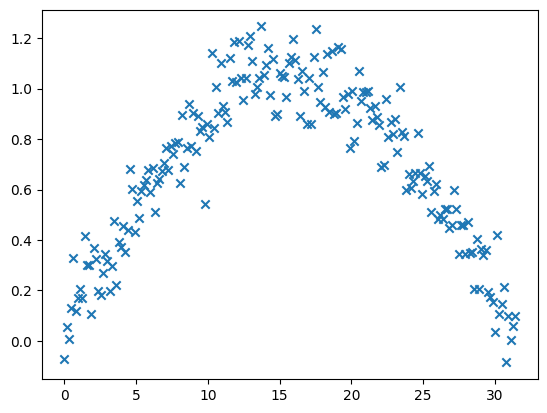

In [252]:
abs = np.linspace(0, 10*np.pi, 200)
np.random.seed(None)
def arc(x):
    return np.sin(x/10) + np.random.normal(0.05, 0.1, 200)

X_arc = np.concatenate((abs.reshape((200, 1)), arc(abs).reshape((200, 1))), axis=1)

fig, ax = plt.subplots(1, 1)
ax.scatter(X_arc[:, 0], X_arc[:, 1], marker = 'x')

Ring and square dataset

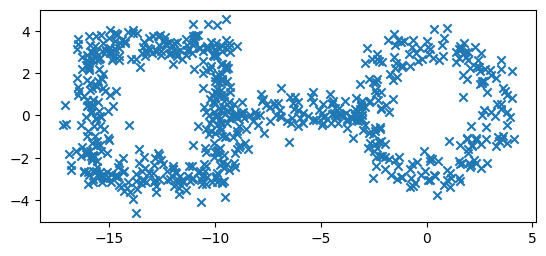

In [253]:
# Number of data points for each component
num_points = 200

# Generate data for a ring
radius = 3
theta_ring = np.linspace(0, 2 * np.pi, num_points)
ring_x = radius * np.cos(theta_ring)
ring_y = radius * np.sin(theta_ring)

# Define the side length of the square
side_length = 6

# Generate points for all sides of the square

# Generate points for the bottom side of the square
bottom_x = np.linspace(-10 - side_length, -10, num_points//2)
bottom_y = np.full(num_points//2, -side_length / 2)

# Generate points for the top side of the square
top_x = np.linspace(-10 - side_length, -10, num_points//2)  # Reversed order
top_y = np.full(num_points//2, side_length / 2)

# Generate points for the left side of the square
left_x = np.full(num_points//2, -10 - side_length)
left_y = np.linspace(-side_length / 2, side_length / 2, num_points//2)

# Generate points for the right side of the square
right_x = np.full(num_points//2, -10)
right_y = np.linspace(side_length / 2, -side_length / 2, num_points//2)  # Reversed order

# Combine all points to create the square dataset
square_x = np.concatenate((bottom_x, right_x, top_x, left_x))
square_y = np.concatenate((bottom_y, right_y, top_y, left_y))

# Generate data for a connecting line
line_x = np.linspace(-3, -10, num_points//2)
line_y = np.zeros(num_points//2)

# Combine the datasets
x = np.concatenate((ring_x, square_x, line_x))
y = np.concatenate((ring_y, square_y, line_y))

x += np.random.normal(0.2, 0.5, len(x))
y += np.random.normal(0.2, 0.5, len(y))

X_ring_and_square = np.concatenate((x.reshape((len(x), 1)), y.reshape((len(y), 1))), axis=1)

plt.scatter(x, y, marker='x')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Python implementation of 'ONLINE LEARNING OF GAUSSIAN MIXTURE MODELS: A TWO-LEVEL APPROACH' by Arnaud Declercq, Justus H. Piater

Global Variables

In [254]:
N = len(X)
n_features = 2
precise_fidelity_threshold = 0.95
uncertain_fidelity_threshold = np.exp(N*np.log(precise_fidelity_threshold)/(chi2.ppf(0.05, N-1)))
point_covariance_matrix = np.eye(2)/1000

Utility functions

In [255]:
def initialize_ecdf(x1, x2):
    new_gaussian1 = (x1, point_covariance_matrix, 1)
    new_gaussian2 = (x2, point_covariance_matrix, 1)
    precise_GMM = [new_gaussian1, new_gaussian2]
    uncertain_GMM = [new_gaussian1, new_gaussian2]
    ecdf = ([], [], [])

    for dim in range(len(x1)):
        intervals = ecdf[0]
        intervals.append(np.linspace(np.min((x1[dim], x2[dim])), np.max((x1[dim], x2[dim])), 10))
        populations = ecdf[1]
        populations.append([1, 0, 0, 0, 0, 0, 0, 0, 0, 1])

        ecdf = (intervals, populations, [])

    

    return precise_GMM, uncertain_GMM, ecdf


def ecdf_update(x, ecdf):
    '''
    Update the empirical cumulative distribution function

    params:
      x: new point
      ecdf: empirical cumulative distribution function
    
    return:
      ecdf: (intervals, population, values)
    '''

    intervals = ecdf[0]
    populations = ecdf[1]
    values = []
    for dim in range(len(intervals)):
        n_dim = len(intervals[dim])
        i = 0
        while i < n_dim and x[dim] > intervals[dim][i]:
            i += 1
        if i == 0:
            intervals[dim] = np.linspace(x[dim], intervals[dim][-1], 10)
            populations[dim][0] += 1
        elif i == n_dim:
            intervals[dim] = np.linspace(intervals[dim][0], x[dim], 10)
            populations[dim][-1] += 1
        else:
          populations[dim][i-1] += 1

        Q = np.sum(populations[dim])
        values_added = []
        for i in range(len(intervals[dim])):
            values_added.append(np.sum(populations[dim][:i])/Q)
        values.append(values_added)

    return intervals, populations, values


def ecdf_evaluate(x, ecdf):
    '''
    Evaluate the empirical cumulative distribution function at x

    params:
      x: point
      ecdf: empirical cumulative distribution function
    
    return:
      result: ecdf evaluated at x
    '''

    result = np.zeros(x.shape[0])
    for dim in range(x.shape[0]):
        i = 0
        while i < len(ecdf[0][dim]) and x[dim] > ecdf[0][dim][i]:
            i += 1
        if i == 0:
            result[dim] = 0
        else:
            result[dim] = ecdf[2][dim][i-1]
    
    return result


def tcdf(GMM, x):
    '''
    Compute the value of the theoretical cumulative distribution function of GMM at x
    '''
    result = np.zeros(n_features)
    for dim in range(n_features):
        mass_total = 0
        for i in range(len(GMM)):
            mass_total += GMM[i][2]
            result[dim] +=  GMM[i][2] * norm(GMM[i][0][dim], GMM[i][1][dim, dim]).cdf(x[dim])
        result[dim] /= mass_total

    return result

    

def fidelity(ecdf, GMM, T_D=0.5):
    '''
    Compute the fidelity of the Gaussian model

    params:
      ecdf: empirical cumulative distribution function
      rcdf: theoretical cumulative distribution function
      T_D: allowed deviation parameter

    return: 
      fidelity
    '''

    differences = np.zeros((len(ecdf[0][0]), n_features))
    
    for i in range(len(ecdf[0][0])):
        point = np.zeros(n_features)
        ecdf_values = np.zeros(n_features)
        for dim in range(n_features):
            point[dim] = ecdf[0][dim][i]
            ecdf_values[dim] = ecdf[2][dim][i]
        differences[i, :] = np.abs(ecdf_values - tcdf(GMM, point))
    
    distance = np.zeros(n_features)
    for dim in range(n_features):
      for i in range((len(ecdf[0][0]))):
          distance[dim] += differences[i, dim] * (ecdf[0][dim][1] - ecdf[0][dim][0])
    distance =  np.sum(distance) / len(ecdf[0][0])
    fidelity = np.exp(-distance**2/T_D**2)

    return fidelity


def nearest_neighbor(x, L):
    '''
    params:
      x: point of which we search the nearest neighbor
      L: list of points among which we search the nearest neighbor

    return:
      near_point_index: the nearest neighbor index
    '''
    dists= [np.linalg.norm((x - L[i])) for i in range(len(L))]
    near_point_index = np.argmin(dists)

    return near_point_index


def get_nearest_precise_GMM(candidate_index, uncertain_GMM, precise_GMM):
    '''
    params:
      candidate_index: index of the candidate in uncertain_GMM
      uncertain_GMM: uncertain GMM list
      precise_GMM: precise GMM list
    
    return:
      nearest_precise_GMM: indexes of precise GMMs that have the candidate as their nearest neighbor in uncertain_GMM
    '''
    nearest_precise_GMM_indexes = []
    for i in range(len(precise_GMM)):
        near_neighbor_index = nearest_neighbor(precise_GMM[i][0], [uncertain_GMM[j][0] for j in range(len(uncertain_GMM))])
        if near_neighbor_index == candidate_index:
            nearest_precise_GMM_indexes.append(i)
    
    return nearest_precise_GMM_indexes        

Process functions

In [256]:
def precise_GMM_reduction(GMM, ecdf, threshold):
    simplified = False
    while not simplified:
        if len(GMM) > 1:
            nearest_neighbor_index = nearest_neighbor(GMM[-1][0], [GMM[j][0] for j in range(len(GMM)-1)])
            candidate = GMM[nearest_neighbor_index]

            new_mass = GMM[-1][2] + candidate[2]
            new_mean = 1/new_mass * (GMM[-1][2] * GMM[-1][0] 
                                    + candidate[2] * candidate[0])
            new_cov = GMM[-1][2]/new_mass * (GMM[-1][1] + np.dot((GMM[-1][0] - new_mean).reshape((GMM[-1][0].shape[0], 1)), (GMM[-1][0] - new_mean).reshape((1, GMM[-1][0].shape[0])))) \
            + candidate[2]/new_mass * (candidate[1] + np.dot((candidate[0] - new_mean).reshape((GMM[-1][0].shape[0], 1)), (candidate[0] - new_mean).reshape((1, GMM[-1][0].shape[0]))))

            mixed_gaussian = (new_mean, new_cov, new_mass)
            mixed_GMM = GMM.copy()
            del mixed_GMM[-1]
            del mixed_GMM[nearest_neighbor_index]
            mixed_GMM.append(mixed_gaussian)
            
            fidel = fidelity(ecdf, mixed_GMM)
            print(fidel)
            if fidel > threshold:
                GMM = mixed_GMM
            else:
                simplified = True
        else:
            simplified = True
    return GMM


def uncertain_GMM_reduction(GMM, ecdf, threshold):
    simplified = False
    while not simplified:
        if len(GMM) > 1:
            nearest_neighbor_index = nearest_neighbor(GMM[-1][0], [GMM[j][0] for j in range(len(GMM)-1)])
            candidate = GMM[nearest_neighbor_index]

            new_mass = GMM[-1][2] + candidate[2]
            new_mean = 1/new_mass * (GMM[-1][2] * GMM[-1][0] 
                                    + candidate[2] * candidate[0])
            new_cov = GMM[-1][2]/new_mass * (GMM[-1][1] + np.dot((GMM[-1][0] - new_mean).T, (GMM[-1][0] - new_mean))) \
            + candidate[2]/new_mass * (candidate[1] + np.dot((candidate[0] - new_mean).T, (candidate[0] - new_mean)))

            mixed_gaussian = (new_mean, new_cov, new_mass)
            mixed_GMM = GMM.copy()
            del mixed_GMM[-1]
            del mixed_GMM[nearest_neighbor_index]
            mixed_GMM.append(mixed_gaussian)

            fidel = fidelity(ecdf, mixed_GMM)

            if fidel > threshold:
                GMM = mixed_GMM

            else:
                GMM = uncertain_GMM_reduction(GMM[:-1], ecdf, threshold) + [GMM[-1]]
                simplified = True
        else:
            simplified = True
    return GMM


def uncertain_GMM_process(uncertain_GMM, precise_GMM, ecdf):
    if len(uncertain_GMM) > 1:
        candidate_index = nearest_neighbor(uncertain_GMM[-1][0], [uncertain_GMM[j][0] for j in range(len(uncertain_GMM)-1)])
        candidate = uncertain_GMM[candidate_index] 

        new_mass = uncertain_GMM[-1][2] + candidate[2]
        new_mean = 1/new_mass * (uncertain_GMM[-1][2] * uncertain_GMM[-1][0] 
                                + candidate[2] * candidate[0])
        new_cov = uncertain_GMM[-1][2]/new_mass * (uncertain_GMM[-1][1] + np.dot((uncertain_GMM[-1][0] - new_mean).T, (uncertain_GMM[-1][0] - new_mean))) 
        + candidate[2]/new_mass * (candidate[1] + np.dot((candidate[0] - new_mean).T, (candidate[0] - new_mean)))
        
        mixed_gaussian = (new_mean, new_cov, new_mass)

        mixed_uncertain_GMM = uncertain_GMM.copy()
        del mixed_uncertain_GMM[-1]
        del mixed_uncertain_GMM[candidate_index]
        mixed_uncertain_GMM.append(mixed_gaussian)
        
        fidel = fidelity(ecdf, mixed_uncertain_GMM)
        
        if fidel > uncertain_fidelity_threshold:
            uncertain_GMM = mixed_uncertain_GMM
        else:
            precise_GMM_indexes = get_nearest_precise_GMM(candidate_index, uncertain_GMM, precise_GMM)
            new_precise_GMM = [precise_GMM[i] for i in precise_GMM_indexes] + [uncertain_GMM[-1]]

            new_uncertain_GMM = uncertain_GMM_reduction([precise_GMM[i] for i in precise_GMM_indexes] 
                                                        + [uncertain_GMM[-1]], ecdf, uncertain_fidelity_threshold)
            del uncertain_GMM[candidate_index]
            del uncertain_GMM[-1]
            uncertain_GMM.extend(new_uncertain_GMM)

            new_precise_GMM = precise_GMM_reduction(new_precise_GMM, ecdf, precise_fidelity_threshold)
            precise_GMM_indexes.sort(reverse=True)
            for i in precise_GMM_indexes:
                del precise_GMM[i]
            precise_GMM.extend(new_precise_GMM)

    return uncertain_GMM, precise_GMM

In [257]:
def online_precise_GMM(X):
    gauss_history = []
    n = X.shape[0]
    #stock the different gaussians with format: (mean, covariance, mass)
    precise_GMM, _, ecdf = initialize_ecdf(X[0], X[1])
    gauss_history.append([precise_GMM[i][0] for i in range(len(precise_GMM))])


    for i in range(2, n):
        print(i)
        ecdf = ecdf_update(X[i], ecdf)
        new_gaussian = (X[i], point_covariance_matrix, 1)
        precise_GMM.append(new_gaussian)
        precise_GMM = precise_GMM_reduction(precise_GMM, ecdf, precise_fidelity_threshold)
        gauss_history.append([precise_GMM[i][0] for i in range(len(precise_GMM))])
    
    return precise_GMM, ecdf, gauss_history

In [258]:
def online_GMM(X):
    n = X.shape[0]
    #stock the different gaussians with format: (mean, covariance, mass)
    precise_GMM, uncertain_GMM, ecdf = initialize_ecdf(X[0], X[1])


    for i in range(2, n):
        print(i)
        ecdf = ecdf_update(X[i], ecdf)
        new_gaussian = (X[i], point_covariance_matrix, 1)
        uncertain_GMM.append(new_gaussian)
        uncertain_GMM, precise_GMM = uncertain_GMM_process(uncertain_GMM, precise_GMM, ecdf)
    
    return uncertain_GMM, precise_GMM

In [259]:
X = np.random.permutation(X_arc)

xmin, ymin = np.min(X, axis=0)[0], np.min(X, axis=0)[1]
xmax, ymax = np.max(X, axis=0)[0], np.max(X, axis=0)[1]

result = online_precise_GMM(X)

2
0.2925920839082658
3
0.6003380365860621
4
0.7508980543123293
5
0.8568034197213132
6
0.8625970380700382
7
0.9147532295271583
8
0.9024683648426588
9
0.9360702652648165
10
0.3506221434433169
11
0.48987366870153976
12
0.5361137737595748
13
0.5770970328622639
14
0.6266294664313906
15
0.6605965278564438
16
0.6939697311797279
17
0.7210954238499925
18
0.722125174948164
19
0.7391807727484305
20
0.7434850536989128
21
0.7791243354261047
22
0.7969802376776668
23
0.8115205026899139
24
0.8242525177747001
25
0.8005481361278255
26
0.8217860467601668
27
0.8037623048920228
28
0.8114327406326849
29
0.8226242884226732
30
0.8199357717439456
31
0.8324762856733391
32
0.8460440065052461
33
0.8537306608172767
34
0.8613691938727803
35
0.8686208507149953
36
0.8749969307598668
37
0.8319558279372672
38
0.834004927760004
39
0.8410302305485692
40
0.8480754881675017
41
0.8546766153050712
42
0.8500611011576786
43
0.8662736122593327
44
0.8717550989864855
45
0.877297108639609
46
0.8817783762703754
47
0.886477710593833

In [260]:
def plot_GMM(GMM, fig, ax):
    x_range = np.linspace(xmin - 1, xmax + 1, 20)
    y_range = np.linspace(ymin - 1, ymax + 1, 20)

    x_mesh, y_mesh = np.meshgrid(x_range, y_range)
    pos = np.c_[x_mesh.ravel(), y_mesh.ravel()]
    z = np.zeros(pos.shape[0])
    for i in range(len(GMM)):
        mean = GMM[i][0]
        cov = GMM[i][1]
        rv = multivariate_normal(mean, cov)
        z += rv.pdf(pos)
    ax.contourf(x_mesh, y_mesh, z.reshape(x_mesh.shape), cmap=plt.cm.coolwarm, zorder = 0)
    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 0.1, ymax + 0.1])


def plot_GMM2(GMM, fig, ax):

    for i in range(len(GMM)):
        # Define the mean and covariance matrix
        mean = GMM[i][0]
        cov_matrix = GMM[i][1]

        # Calculate the eigenvalues and eigenvectors of the covariance matrix
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # Calculate the angle of rotation for the ellipse
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))


        # Create and add the ellipse to the plot
        ellipse = patches.Ellipse(xy=mean, width=2 * np.sqrt(5.991 * eigenvalues[0]), height=2 * np.sqrt(5.991 * eigenvalues[1]),
                                angle=angle, fill=False, color='b')
        ax.add_patch(ellipse)

        # Set axis limits and labels
        ax.set_xlim(xmin-1, xmax+1)
        ax.set_ylim(ymin-0.1, ymax+0.1)

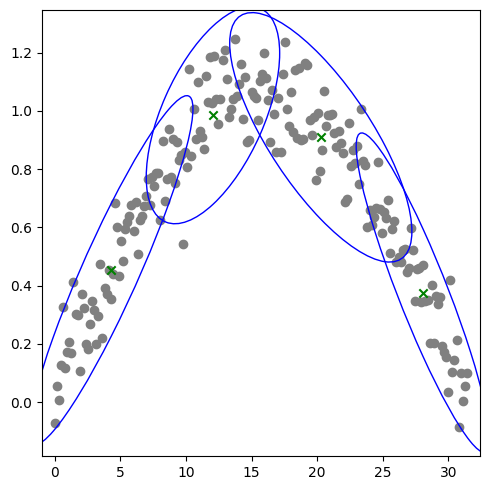

In [264]:
means = [result[0][i][0] for i in range(len(result[0]))]
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(x=X[:, 0], y=X[:, 1], color='grey', zorder = 1)
ax.scatter(x=[means[i][0] for i in range(len(means))], y=[means[i][1] for i in range(len(means))], marker = 'x', color='g', zorder=2)
plot_GMM2(result[0], fig, ax)
#plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()

In [262]:
frames = [(np.array(result[2][i]), X[i+1]) for i in range(len(result[2]))]

MovieWriter imagemagick unavailable; using Pillow instead.


C:\Users\SL276123\AppData\Local\Temp\ipykernel_2992\2077303857.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


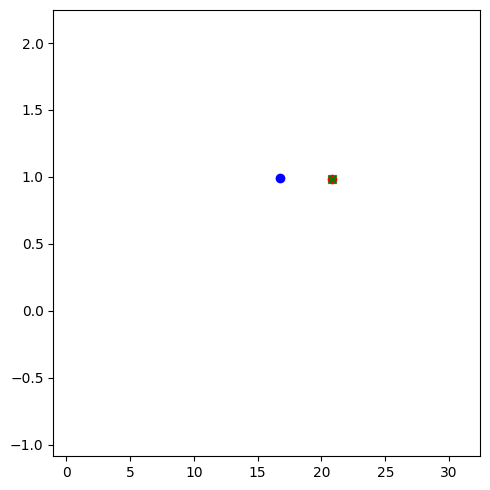

In [263]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

def update(frame):
    # clear the axis each frame
    ax.clear()
    
    # replot things
    ax.scatter(frame[0][:-1, 0], frame[0][:-1, 1], color='blue')
    ax.scatter(frame[0][-1, 0], frame[0][-1, 1], color='red')
    ax.scatter(frame[1][0], frame[1][1], color='green', marker='x')
    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])
    plt.tight_layout()

anim = FuncAnimation(fig, update, frames=frames, interval=10000)

anim.save('./animation.gif', writer='imagemagick', fps=10)